### test for plotting pft level data on h1 files
Created by Will Wieder
Improved by Orhan Eroglu
March 2025

In [1]:
import os, sys
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import xesmf as xe

# Helpful for plotting only
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import uxarray as ux  #need npl 2024a or later
import geoviews.feature as gf

print(ux.__version__)
#sys.path.append('/glade/u/home/wwieder/python/adf/lib/plotting_functions.py')

2025.6.0


In [2]:
# Load datataset
# TODO, load with adf tools and config file options
h0_file='/glade/derecho/scratch/wwieder/archive/ctsm5.4_5.3.068_PPEcal115_116_HIST/lnd/hist/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h0a.1930-11.nc'
#laih1file='/glade/derecho/scratch/wwieder/ctsm53n04ctsm52028_ne30pg3t232_hist.clm2.h1.TLAI.1860s.nc'
laih1file='/glade/derecho/scratch/wwieder/TLAI_cat/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h1a.TLAI.1850s.nc'
case = 'ctsm5.4_5.3.068_PPEcal115_116_HIST'

mesh0 = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'

#ux file for plotting
uxds0 = ux.open_dataset(mesh0, h0_file).max('time')
uxds1 = ux.open_dataset(mesh0, laih1file).max('time')

# Assign coords to uxds0, which will be needed later for align() operation
n_face_coords = np.arange(1,(uxds1.pfts1d_ixy.max().astype(int)+1))
uxds0 = uxds0.assign_coords({'n_face': ('n_face', n_face_coords)})


In [3]:
def reshape_ux_h1(uxds1, uxds0, var='TLAI', npft=15):
    """
    Reshape unstructured data from h1 history files:
        - Inputs 1d data from uxarray dataset (pft) into
        - Returns 2d uxarray dataset (pft x n_face)
        - Also include area + landfrac data, taken here from h0 dataset

    Requires h1 and h0 datasets that include the target variable
    By default this function only runs on the native pfts

    """

    for i in range(1, npft):
        temp = uxds1.where(uxds1.pfts1d_itype_veg==i, drop=True)
        # TODO, PFT weights should be time evolving, but they aren't here
        # Rename coord, since the pft dimension is not meaningful
        temp= temp.rename({'pft': 'n_face'})

        # assign values from pfts1d_ixy to n_face
        temp['n_face'] = temp.pfts1d_ixy.astype(int)
        temp.assign_coords({"npft": i})

        # combine along PFT variable
        if i == 1:
            uxdsOut = temp
        else:
            uxdsOut = xr.concat([uxdsOut, temp], dim="npft")

    uxdsOut.uxgrid = temp.uxgrid
    uxdsOut, _ = xr.align(uxdsOut, uxds0[var], join="right")
    # now copy over area & landfrac
    uxdsOut['area'] = uxds0.area
    uxdsOut['landfrac'] = uxds0.landfrac
    return uxdsOut

In [4]:
# Call the reshape_ux_h1 function
npft=15
var='TLAI'
uxdsOut = reshape_ux_h1(uxds1, uxds0, var, npft)

In [5]:
# Read in pft names
pft_constants = xr.open_dataset(
    '/glade/campaign/cesm/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm60_params.c241017.nc')
pft_names = pft_constants.pftname

'''
Or hard code them
pft_names = ['NET Temperate', 'NET Boreal', 'NDT Boreal',
             'BET Tropical', 'BET Temperate', 'BDT Tropical',
             'BDT Temperate', 'BDT Boreal', 'BES Temperate',
             'BDS Temperate', 'BDS Boreal', 'C3 Grass Arctic',
             'C3 Grass', 'C4 Grass', 'UCrop UIrr']
'''

"\nOr hard code them\npft_names = ['NET Temperate', 'NET Boreal', 'NDT Boreal',\n             'BET Tropical', 'BET Temperate', 'BDT Tropical',\n             'BDT Temperate', 'BDT Boreal', 'BES Temperate',\n             'BDS Temperate', 'BDS Boreal', 'C3 Grass Arctic',\n             'C3 Grass', 'C4 Grass', 'UCrop UIrr']\n"

In [6]:
# TODO Add this to ADF plotting functions?
def plot_ux_survival(uxdsOut, case=case, var='TLAI', npft = 15,
                     pft_names = pft_names, min_pft_wgt = 0.05):
    '''
    Accepts reshaped h1 file from unstructured grid
      - Also requires case name, variable, and PFT names (strings), and
      - min value for PFT weights (fraction of grid cell) as a mask
    Currently hard coded to make nice PFT survival plots, but 
    Could be adapted for more general subgid output
    '''

    # Basic plot settings
    transform = ccrs.PlateCarree()
    proj = ccrs.PlateCarree()
    cmap = plt.cm.viridis_r
    cmap.set_under(color='deeppink')
    cmap = cmap.resampled(7)
    levels = [0.1, 1, 2, 3, 4, 5, 6, 7]

    # create figure object
    fig, axs = plt.subplots(5,3,
        facecolor="w",
        constrained_layout=True,
        subplot_kw=dict(projection=proj),
        dpi=300)

    axs=axs.flatten()

    # Loop over pfts
    for i in range((npft-1)):
        # Calculate weights bases on area, landfrac and min_pft_wgt
        pft_wgt = uxdsOut.pfts1d_wtgcell.isel(npft=i)
        pft_wgt = pft_wgt.where(pft_wgt >= min_pft_wgt)
        wgts = uxdsOut.area * uxdsOut.landfrac * pft_wgt
        wgts = wgts / wgts.sum()

        # Plots where LAI > min_wgt on grid
        axs[i].set_global()
        plot_var = uxdsOut[var].isel(npft=i).where(pft_wgt >= min_pft_wgt)
        raster = plot_var.to_raster(ax=axs[i])
        img = axs[i].imshow(
            raster, cmap=cmap, origin="lower", extent=axs[i].get_xlim() + axs[i].get_ylim()
        )
        img.set_clim(vmin=0.1,vmax=6.9)

        # Add titles (pft names) & statistics (mean LAI & survival)
        mean = str(np.round((uxdsOut[var].isel(npft=i)*wgts).sum().values,2))
        dead = ((uxdsOut[var].isel(npft=i)<0.1)*wgts).sum()
        live = ((uxdsOut[var].isel(npft=i)>0.1)*wgts).sum()
        livefrac = str(np.round((live/(live+dead)).values,2))
        axs[i].set_title(str(pft_names[(1+i)].data)[12:50], loc='left',size=6)
        axs[i].text(-30, -45,'mean = '+ mean, fontsize=5)
        axs[i].text(-45, -60,'live frac = '+livefrac,fontsize=5)

    # make panels look nice
    for a in axs:
        a.coastlines().set_linewidth(0.1)
        a.set_global()
        a.spines['geo'].set_linewidth(0.1) #cartopy's recommended method
        a.set_extent([-180, 180, -65, 86])

    # add color bar with case name
    fig.set_layout_engine("compressed")
    cbar_ax = fig.add_axes([0.94, 0.06, 0.02, 0.88])
    cbar = fig.colorbar(img, cax=cbar_ax, pad=0.1, shrink=0.7, aspect=40, extend='both')
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label(label=("max LAI "+case), size=9, weight='bold')

    return fig


-- wrote pft TLAI figure --


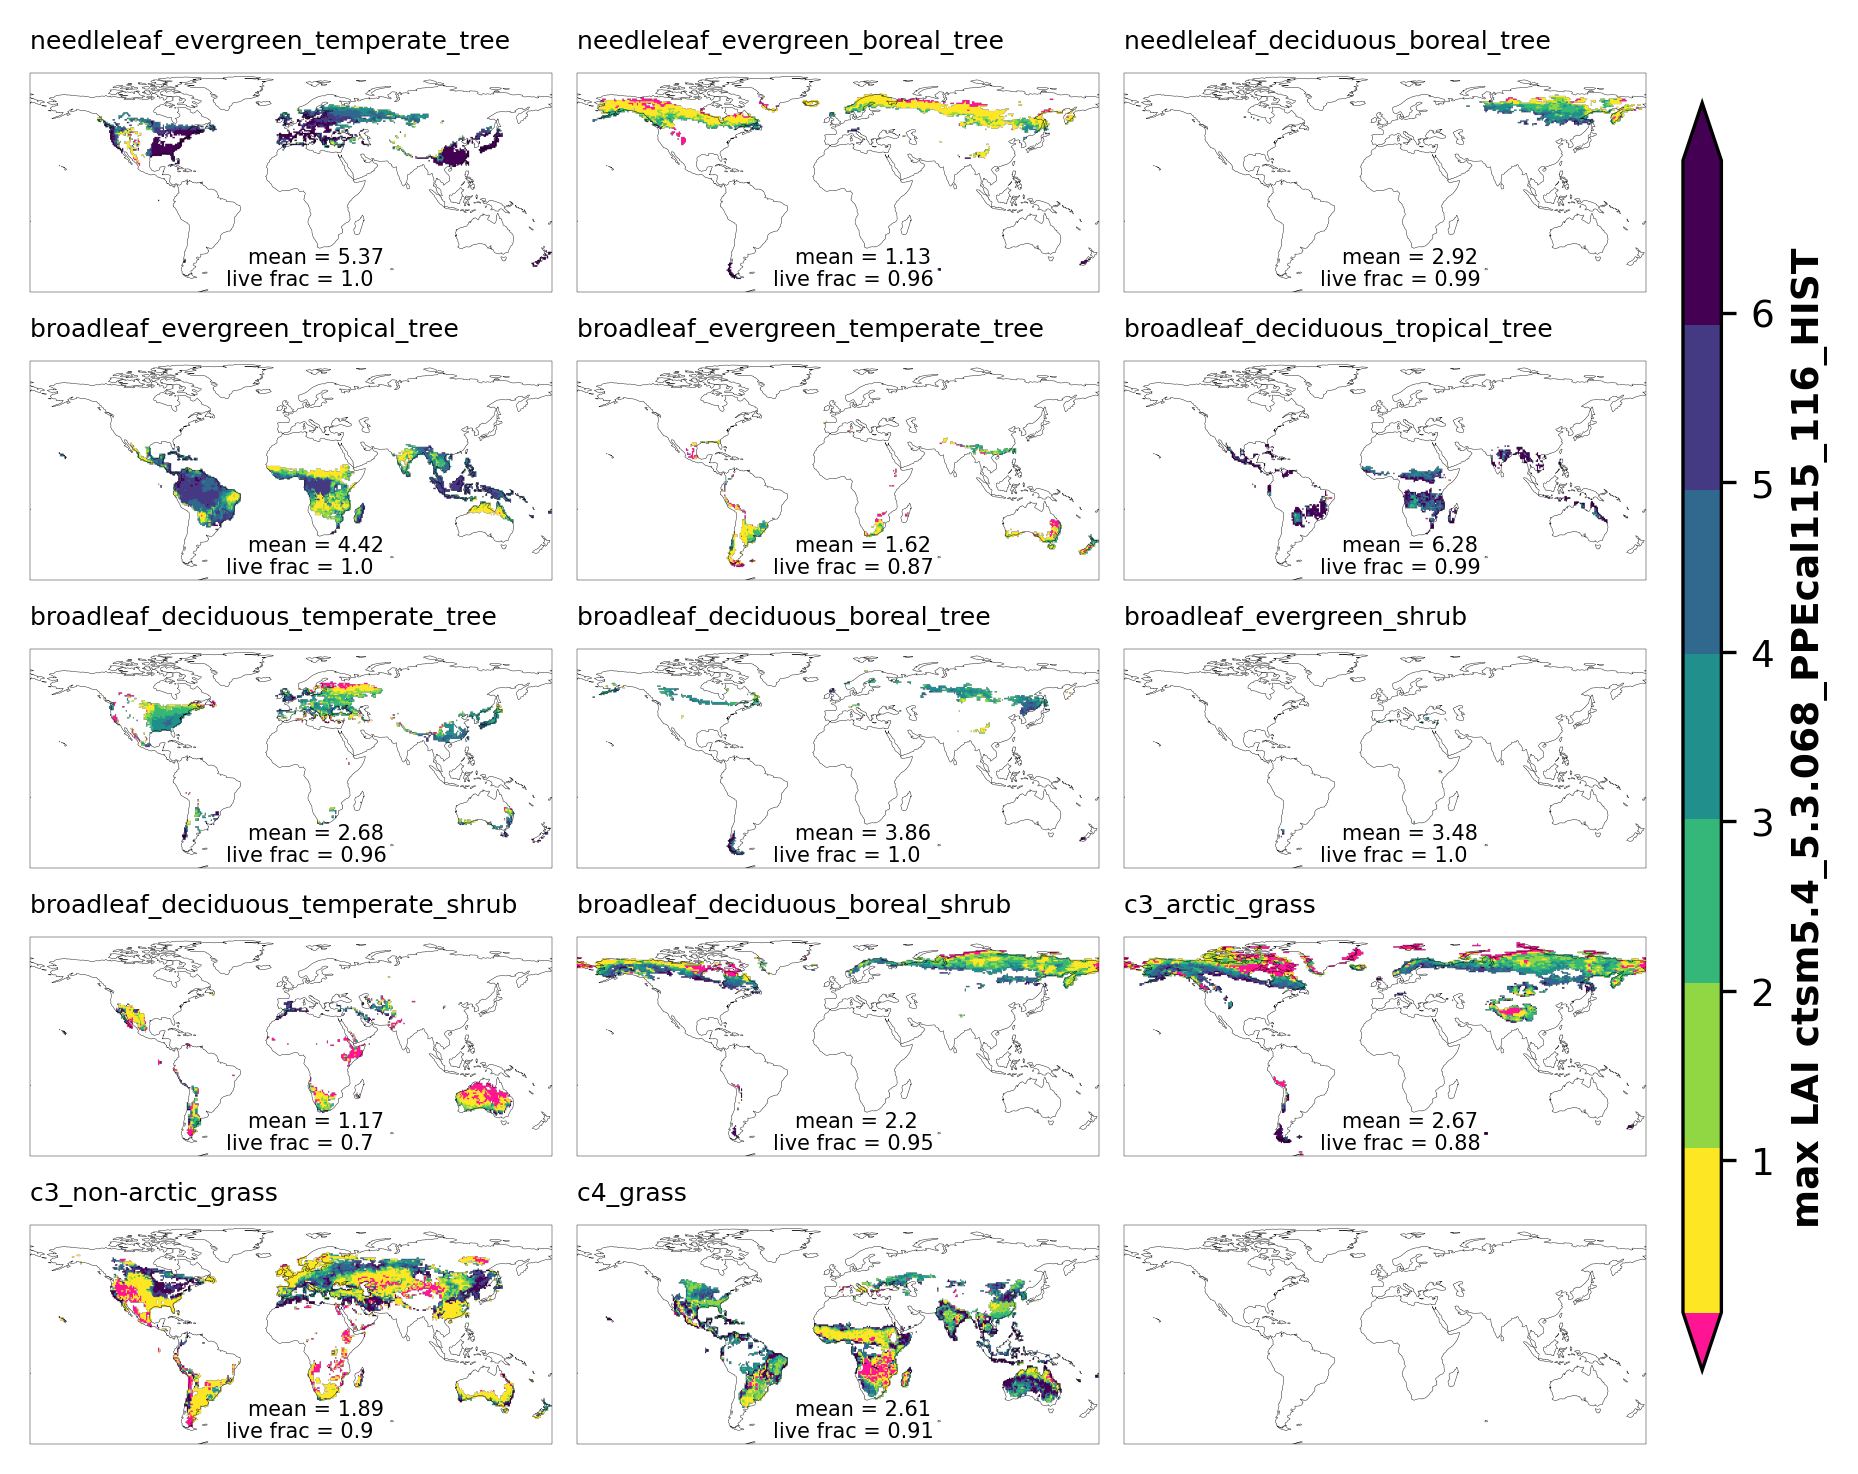

CPU times: user 32.1 s, sys: 115 ms, total: 32.2 s
Wall time: 39.7 s


In [7]:
%%time
# Call plotting function
fig = plot_ux_survival (uxdsOut = uxdsOut, case = case, var = var,
                        pft_names = pft_names, min_pft_wgt = 0.05)
save = True
# TODO add ADF plotting and webpage hooks
if (save == True):
    fig.savefig('h1_test_raster', bbox_inches='tight', dpi=300)
    print('-- wrote pft '+var+' figure --')
plt.show() ;